## Laboratorio 1
### Data Science
### Series de timpo

Javier Ovalle, 
José Ángel Morales, 
Ricardo Morales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [10]:

dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
imp = pd.read_csv('IMPORTACIONES.csv', parse_dates=['Fecha'], index_col='Fecha', date_parser=dateparse)
print('\n Parsed Data:')
imp['Diesel'].head()

train_size = int(len(imp) * 0.7)
train_imp = imp[0:train_size]
test_imp = imp[train_size:len(imp)]



 Parsed Data:


C:\Users\Javier Chiquin\AppData\Local\Temp\ipykernel_5220\1887415660.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  imp = pd.read_csv('IMPORTACIONES.csv', parse_dates=['Fecha'], index_col='Fecha', date_parser=dateparse)


In [19]:
ts_imp_D = train_imp['Diesel']
ts_imp_D.tail(10)

Fecha
2017-04-01    1406022.43
2017-05-01     889926.86
2017-06-01     902659.00
2017-07-01     994338.30
2017-08-01     846696.35
2017-09-01     925397.87
2017-10-01     740198.57
2017-11-01    1135350.10
2017-12-01    1305047.55
2018-01-01    1153831.89
Name: Diesel, dtype: float64

### Modelo Arima


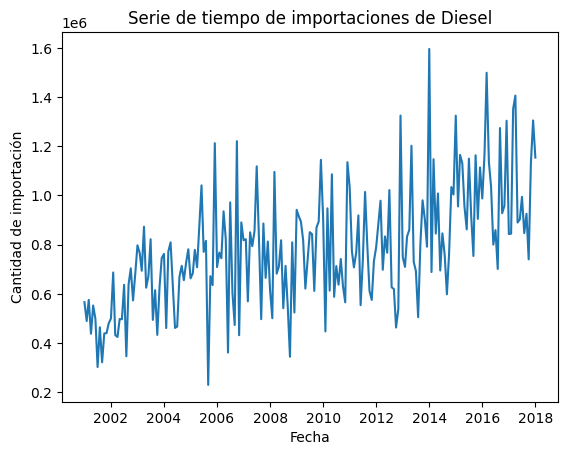

In [23]:
plt.plot(ts_imp_D)
plt.gca().set(title="Serie de tiempo de importaciones de Diesel", xlabel="Fecha", ylabel="Cantidad de importación")
plt.show()

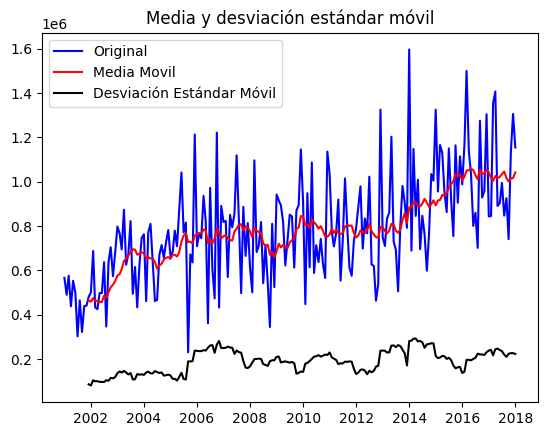

In [26]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = ts_imp_D.rolling(window=12).mean()
deMovil = ts_imp_D.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_D, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

Media móvil (rojo): Muestra claramente la tendencia creciente de las importaciones.

Desviación estándar móvil (negro): Indica que la variabilidad también aumenta con el tiempo, lo que es típico en series no estacionarias.

Serie original (azul): Se aprecian fluctuaciones y picos, pero la tendencia general es al alza.

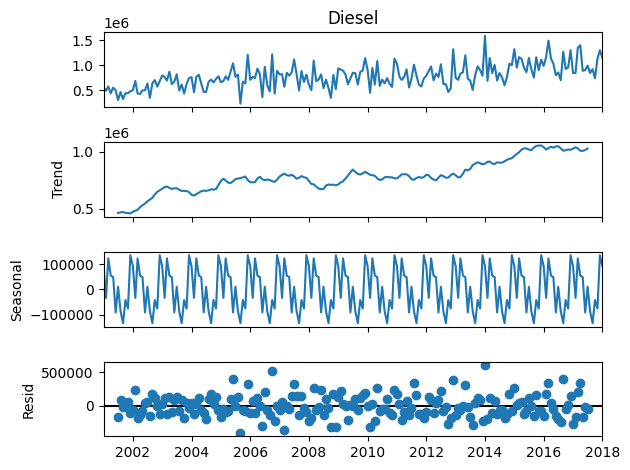

In [29]:
descomposicion = seasonal_decompose(ts_imp_D)
descomposicion.plot();

Tendencia: Se observa un crecimiento sostenido a lo largo de los años.

Estacionalidad: Hay un patrón estacional anual muy claro, con oscilaciones regulares cada año.

Residuales: Los residuos parecen estar centrados en cero, aunque con cierta variabilidad, lo que indica que la descomposición captura bien la tendencia y la estacionalidad.

## Estimar parámetros

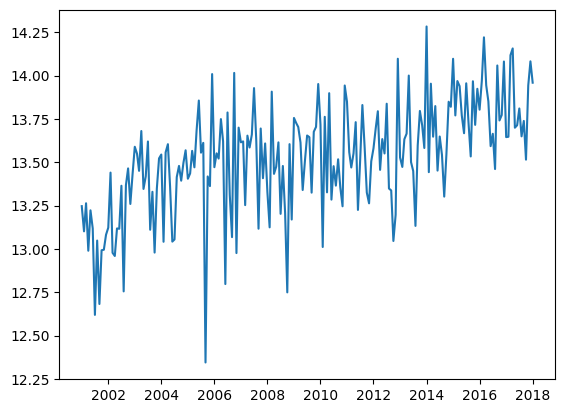

In [31]:
ts_imp_D_log = np.log(ts_imp_D)
plt.plot(ts_imp_D_log)

In [32]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_D, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.450874
p-value                        0.557658
# de retardos usados          13.000000
# de observaciones usadas    191.000000
Critical Value (1%)           -3.465059
Critical Value (5%)           -2.876794
Critical Value (10%)          -2.574901
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [33]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_D_diff = ts_imp_D.diff()
ts_imp_D_diff.dropna(inplace=True)
dfTest = adfuller(ts_imp_D_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.777089e+00
p-value                      8.611615e-12
# de retardos usados         1.200000e+01
# de observaciones usadas    1.910000e+02
Critical Value (1%)         -3.465059e+00
Critical Value (5%)         -2.876794e+00
Critical Value (10%)        -2.574901e+00
dtype: float64


El valor P es menor a 0.05, por lo que se puede rechazar la hipótesis nula y se puede decir que no hay raices unitarias.

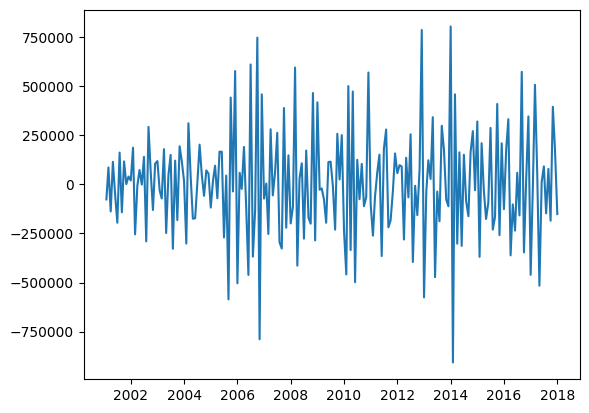

In [34]:
plt.plot(ts_imp_D_diff)

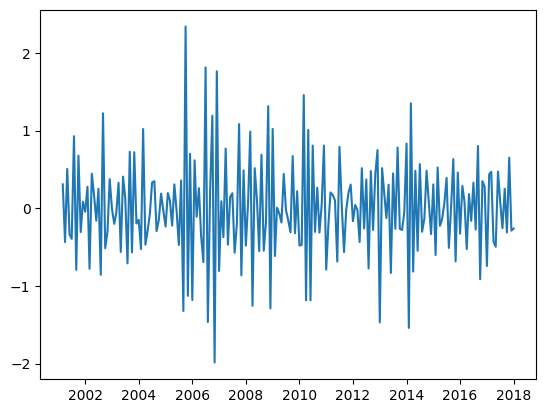

In [35]:
plt.plot(ts_imp_D_log.diff().diff())

Podemos decir que la serie es estacionaria ahora en media y en varianza. Toca ahora estimar los parámetros del modelo.

### Funciones de autocorrelación
#### Modelos teóricos


| Modelo    |                FAC                |                FACP               |
|-----------|:---------------------------------:|:---------------------------------:|
|   **MA(q)**   |         Se anula para j>q         | Decrecimiento rápido. No se anula |
|   **AR(p)**   | Decrecimiento rápido. No se anula |         Se anula para j>p         |
| **ARMA(p,q)** | Decrecimiento rápido. No se anula | Decrecimiento rápido. No se anula |  

In [36]:
ts_imp_D_log_diff = ts_imp_D_log.diff().diff()
ts_imp_D_log_diff.dropna(inplace = True)
tsa_acf = acf(ts_imp_D_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(ts_imp_D_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.70411531,  0.24810124, -0.03828802, -0.06760689,
        0.1375692 ])